## DAT402 - Project 2
Created by Saketh Pabolu and Anish Kolan

In [1]:
### Library Imports
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os
from pathlib import Path
from PIL import Image

import kagglehub

pd.set_option('display.max_colwidth', None)

# download dataset from kagglehub
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")
print("Path to dataset files:", path)

/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/saketh/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


# Problem Definition & Motivation

We are using the dataset "Cards Image Dataset-Classification" with 7624 train images, 265 test images, and 265 validation images. 
https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification 

Each image is 224 X 224 size with RGB values denoted (224, 224, 3).

**Goal**

Build a model that, given a photo of a playing card, predicts which card it is (e.g. "ace of hearts", "king of spades", etc.).

**Why it's interesting**:
- Real-world vision challenge: cards vary in orientation, lighting, occlusion, background clutter.
- Hierarchical structure: each card has a rank (A, 2…K) and a suit (♥, ♣, ♦, ♠).
- Can be framed as a flat 53-way classification or a multi‐output (rank + suit) problem.
- Practical applications in gaming, casino surveillance, and vision systems that need to recognize structured objects.

**Dataset**:
- Stored in `train/`, `valid/`, `test/` subfolders, one folder per class (e.g. `ace of hearts`, `two of spades`, …, `joker`).

## Preprocessing

We want to load all the folders using Path library and storing the file paths in train, valid and test directory variables.

In [2]:
DATA_ROOT = Path(path)

train_dir = DATA_ROOT / 'train'
valid_dir = DATA_ROOT / 'valid'
test_dir  = DATA_ROOT / 'test'

print("Train folder:", train_dir.resolve())
print("Valid folder:", valid_dir.resolve())
print("Test  folder:", test_dir.resolve())

Train folder: /Users/saketh/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train
Valid folder: /Users/saketh/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/valid
Test  folder: /Users/saketh/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test


Now we want to view all types of cards we have to understand different types of cards within each folder.

In [3]:
train_classes = [folder.name for folder in train_dir.iterdir()
                 if folder.is_dir()]
print(f"Dataset classes in the training folder ({len(train_classes)}):")
for card_class in train_classes:
    print(card_class)

Dataset classes in the training folder (53):
ten_of_hearts
jack_of_clubs
queen_of_spades
six_of_clubs
five_of_hearts
queen_of_clubs
two_of_spades
jack_of_spades
four_of_hearts
king_of_hearts
four_of_clubs
ace_of_diamonds
four_of_diamonds
three_of_hearts
king_of_diamonds
nine_of_hearts
ace_of_spades
six_of_spades
ace_of_clubs
seven_of_spades
nine_of_clubs
seven_of_diamonds
two_of_diamonds
eight_of_spades
nine_of_spades
ace_of_hearts
six_of_hearts
jack_of_diamonds
eight_of_clubs
three_of_spades
ten_of_clubs
ten_of_diamonds
three_of_clubs
eight_of_hearts
seven_of_clubs
seven_of_hearts
queen_of_hearts
two_of_clubs
five_of_clubs
joker
five_of_spades
queen_of_diamonds
six_of_diamonds
ten_of_spades
eight_of_diamonds
four_of_spades
king_of_spades
nine_of_diamonds
three_of_diamonds
two_of_hearts
king_of_clubs
five_of_diamonds
jack_of_hearts


We noticed that each class type has a folder with spaces in the text. For example, "ace of spades" has two spaces. When converting this dataset into our own dataframe, these spaces cause issues with folder retrieval.

To avoid this issue, We want to replace each of the spaces of the folders with underscores to access the images without issues.

In [4]:
def update_folder_names(directory):
    for folder in os.listdir(directory):
        if ' ' in folder:
            old_path = os.path.join(directory, folder)
            new_folder_name = folder.replace(' ', '_')
            new_path = os.path.join(directory, new_folder_name)
            os.rename(old_path, new_path)

update_folder_names(train_dir)
update_folder_names(valid_dir)
update_folder_names(test_dir)

As we continue in our pre-processing section, we aim to use the traditional deck of playing cards (Diamond, Club, Spade, Hearts, and cards numbers from 2-10, Jack, Queen, King, Ace)

Therefore, we will drop the Joker class to narrow our machine learning model methods.

In a real world environment, this model would help with employers in the casino industry for identifying cards efficiently.

We will first create a `pandas` dataframe with the file paths from before. Next, we will remove the Joker class.

In [5]:
# function to create a DataFrame with file paths and labels
def create_dataframe(directory):
    data = []
    for folder in directory.iterdir():
        if folder.is_dir():
            label = folder.name
            for file in folder.glob("*.jpg"):
                data.append({"file_path": str(file), "label": label})
    return pd.DataFrame(data)

train_df = create_dataframe(train_dir)
valid_df = create_dataframe(valid_dir)
test_df = create_dataframe(test_dir)

# remove the Joker class from the DataFrames
train_df = train_df[train_df["label"] != "joker"]
valid_df = valid_df[valid_df["label"] != "joker"]
test_df = test_df[test_df["label"] != "joker"]

unique_classes = train_df["label"].unique()
print(f"Total unique classes: {len(unique_classes)},")
for card_class in unique_classes:
    print(card_class)

Total unique classes: 52,
ten_of_hearts
jack_of_clubs
queen_of_spades
six_of_clubs
five_of_hearts
queen_of_clubs
two_of_spades
jack_of_spades
four_of_hearts
king_of_hearts
four_of_clubs
ace_of_diamonds
four_of_diamonds
three_of_hearts
king_of_diamonds
nine_of_hearts
ace_of_spades
six_of_spades
ace_of_clubs
seven_of_spades
nine_of_clubs
seven_of_diamonds
two_of_diamonds
eight_of_spades
nine_of_spades
ace_of_hearts
six_of_hearts
jack_of_diamonds
eight_of_clubs
three_of_spades
ten_of_clubs
ten_of_diamonds
three_of_clubs
eight_of_hearts
seven_of_clubs
seven_of_hearts
queen_of_hearts
two_of_clubs
five_of_clubs
five_of_spades
queen_of_diamonds
six_of_diamonds
ten_of_spades
eight_of_diamonds
four_of_spades
king_of_spades
nine_of_diamonds
three_of_diamonds
two_of_hearts
king_of_clubs
five_of_diamonds
jack_of_hearts


## Exploratory Data Analysis

The dataset is pre-grouped in train, test and validation split. We will now view the train/test/validation split with the dataframe and display the split.

In [6]:
# display dataset split statistics
print("\nThe Train/Test/Validation Split:")
train_count = len(train_df)
print("# of Train Images:", train_count)

test_count = len(test_df)
print("# of Test Images:", test_count)

valid_count = len(valid_df)
print("# of Validation Images:", valid_count)

total_count = train_count + test_count + valid_count
train_ratio = np.round(train_count / total_count, 2)
test_ratio = np.round(test_count / total_count, 2)
valid_ratio = np.round(valid_count / total_count, 2)

print(f"Train/Test/Validation Ratios: {train_ratio}/{test_ratio}/{valid_ratio}")

# show class distribution in training set
print("\nAmount of Cards in Each Class - Train:")
train_class_amts = train_df['label'].value_counts()

for ind, card, amount in zip(range(0, len(train_class_amts)), train_class_amts.index, train_class_amts):
    print(f"{ind + 1:02}. {card}\t{amount}")

train_count = len(train_df)
print(f"\nTotal\t\t\t{train_count}")


The Train/Test/Validation Split:
# of Train Images: 7509
# of Test Images: 260
# of Validation Images: 260
Train/Test/Validation Ratios: 0.94/0.03/0.03

Amount of Cards in Each Class - Train:
01. ace_of_spades	181
02. jack_of_spades	172
03. jack_of_clubs	171
04. ace_of_hearts	171
05. jack_of_hearts	168
06. seven_of_spades	165
07. queen_of_diamonds	163
08. queen_of_spades	162
09. queen_of_clubs	161
10. jack_of_diamonds	160
11. eight_of_diamonds	159
12. ten_of_spades	158
13. six_of_spades	158
14. five_of_spades	158
15. four_of_clubs	157
16. two_of_hearts	155
17. two_of_spades	155
18. four_of_hearts	154
19. nine_of_spades	154
20. three_of_diamonds	153
21. six_of_clubs	152
22. eight_of_hearts	152
23. king_of_spades	151
24. ten_of_diamonds	151
25. five_of_clubs	150
26. seven_of_hearts	143
27. three_of_spades	142
28. ten_of_clubs	141
29. four_of_spades	140
30. queen_of_hearts	139
31. six_of_diamonds	139
32. eight_of_clubs	138
33. five_of_diamonds	138
34. five_of_hearts	136
35. eight_of_spad

We can see the train/test/validation split based on the number of images that are allocated to each split type. The output also shows the total amount of cards in each class for reference.

Now, let's view some examples of the cards and their respective labels to get an understanding of the different types of images that are in our dataset.

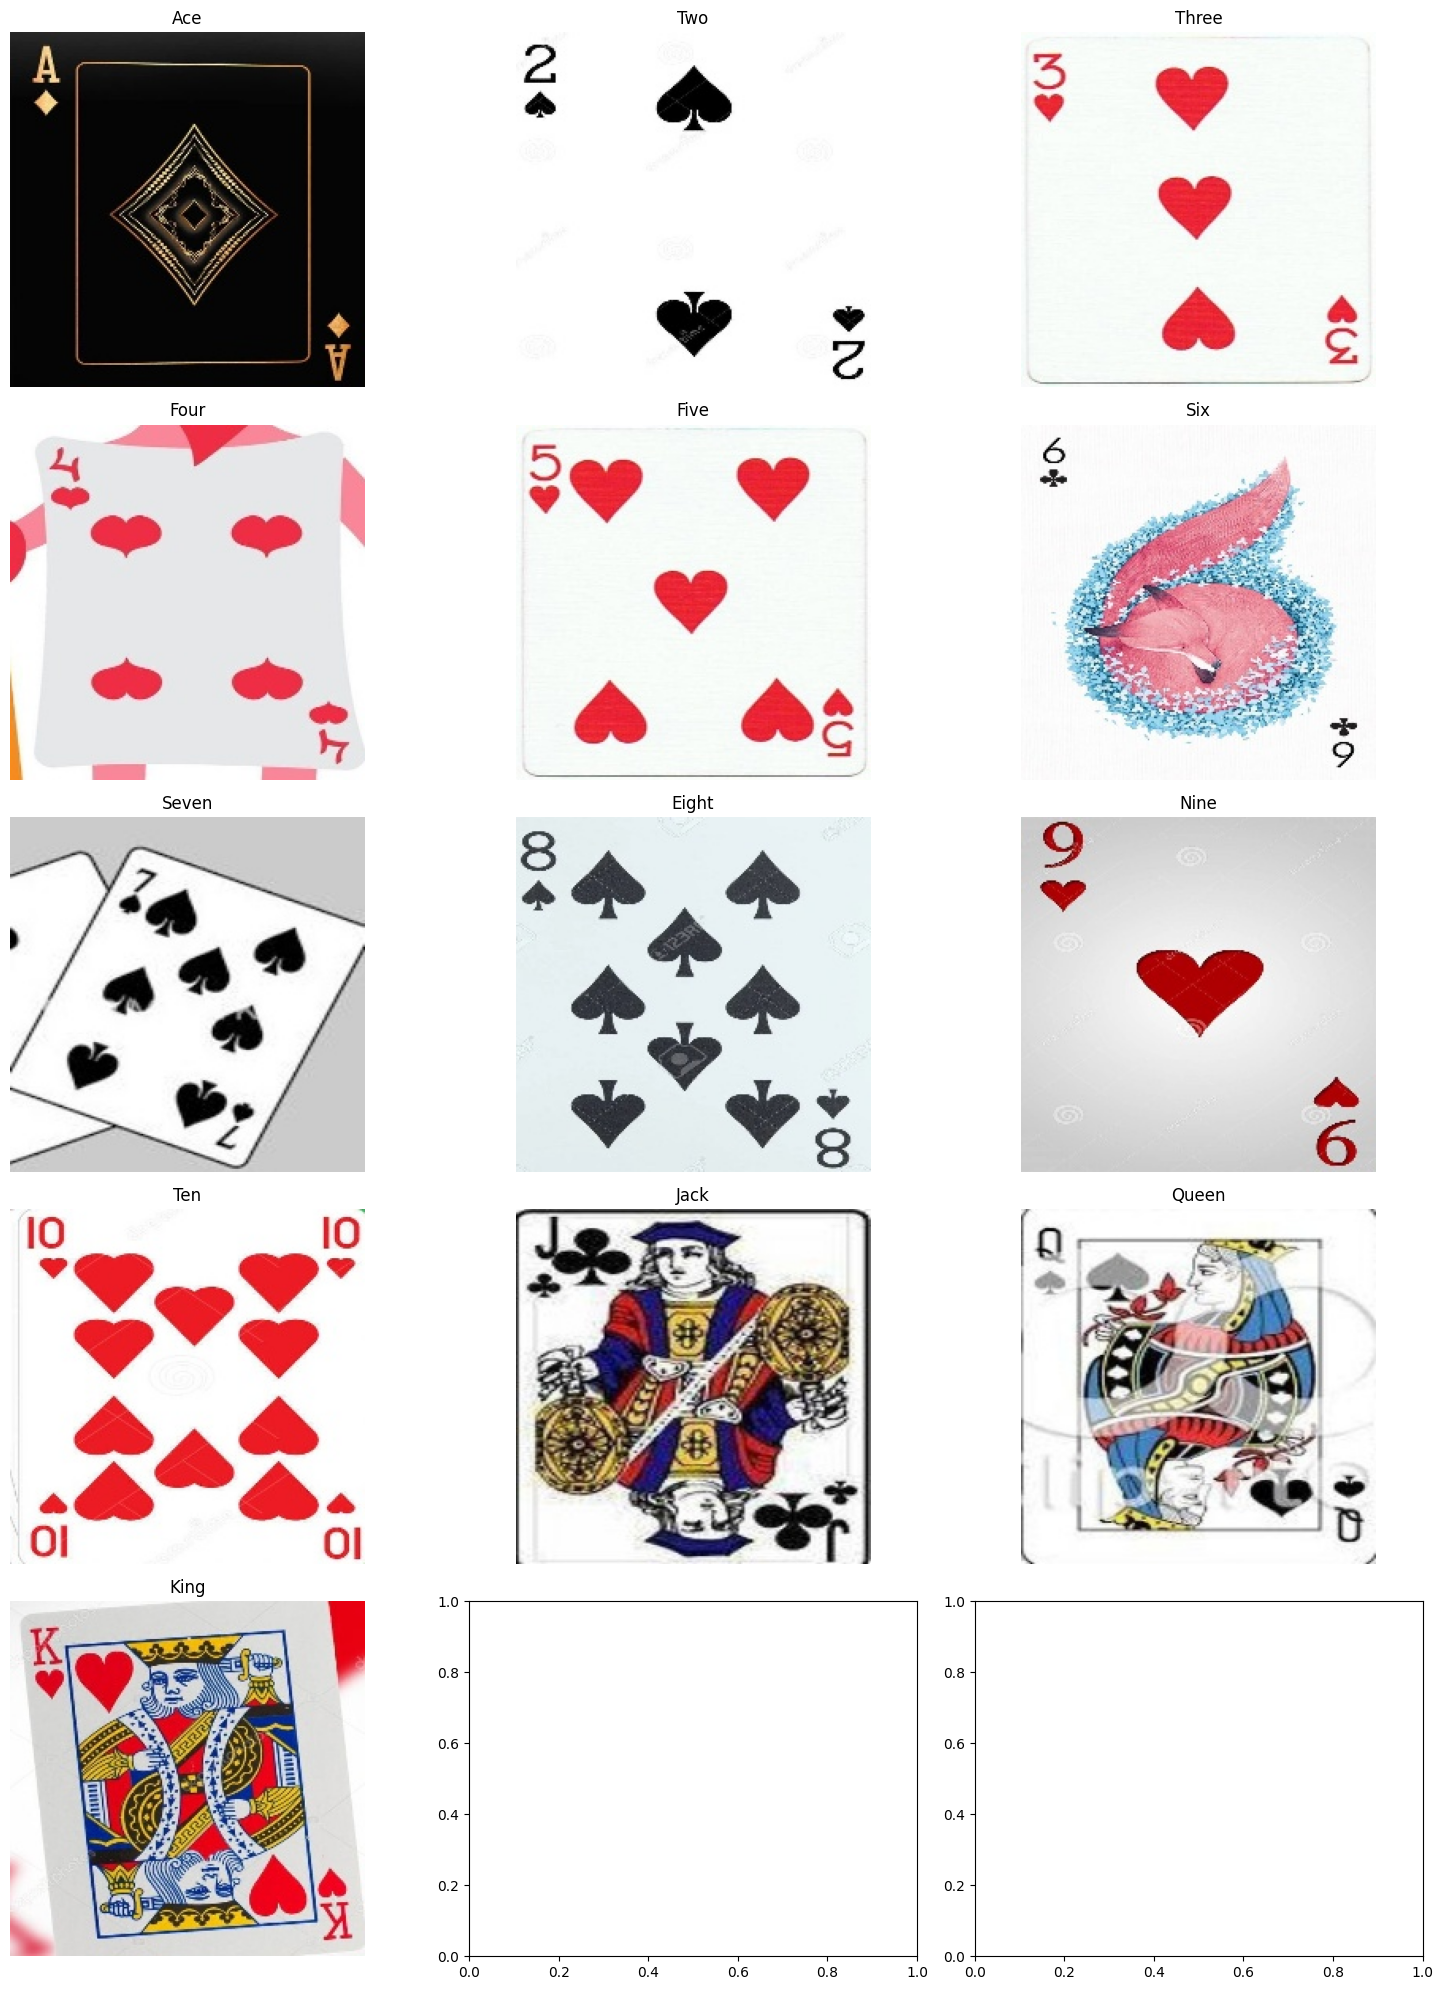

In [7]:
face_values = ['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 
                'eight', 'nine', 'ten', 'jack', 'queen', 'king']

face_value_examples = {}
for face_value in face_values:
    matching_rows = train_df[train_df['label'].str.startswith(face_value)]
    if not matching_rows.empty:
        face_value_examples[face_value] = matching_rows.iloc[0]['file_path']

fig, axs = plt.subplots(5, 3, figsize=(15, 20))
axs = axs.flatten()

# show each card using matplotlib and pillow
for i, face_value in enumerate(face_values):
    if face_value in face_value_examples:
        try:
            img = Image.open(face_value_examples[face_value])
            axs[i].imshow(img)
            axs[i].set_title(f"{face_value.title()}", fontsize=12)
        except Exception as e:
            print(f"Error displaying {face_value}: {e}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Let's also display one example of each suit to better understand the visual differences:

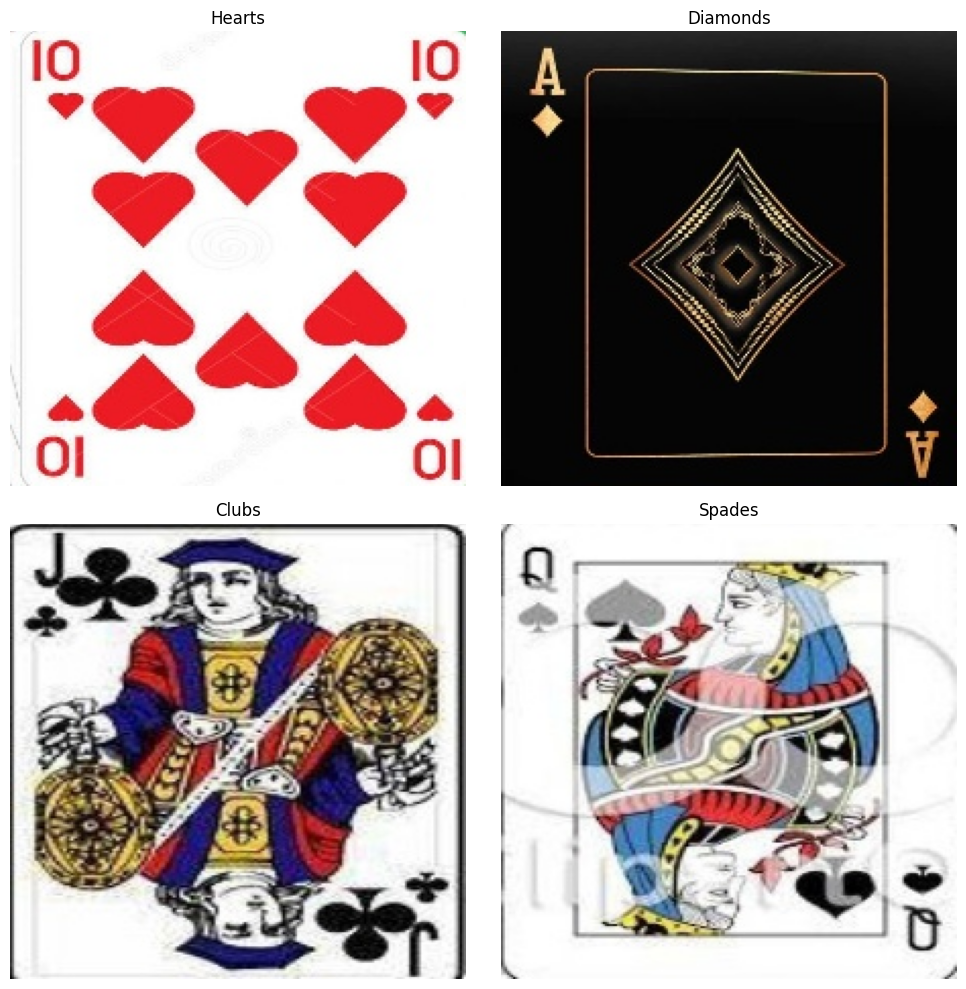

In [8]:
suits = ['hearts', 'diamonds', 'clubs', 'spades']
suit_examples = {}
for suit in suits:
    matching_rows = train_df[train_df['label'].str.endswith(suit)]
    if not matching_rows.empty:
        suit_examples[suit] = matching_rows.iloc[0]['file_path']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

# show each card using matplotlib and pillow
for i, suit in enumerate(suits):
    if suit in suit_examples:
        try:
            img = Image.open(suit_examples[suit])
            axs[i].imshow(img)
            axs[i].set_title(f"{suit.title()}", fontsize=12)
        except Exception as e:
            print(f"Error displaying {suit}: {e}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Let's move to the next step which involves loading the training data into a `numpy` array. Before we create the arrays, the images need to be in a readable format for Tensorflow. Using the `img_to_array` and `load_img` methods from Tensorflow library, the `.jpeg` files are loaded and converted into numerical arrays with RGB channels in the shape (224, 224, 3) per image. As of right now, our data is all with file paths, so we need to make an array with the image data.

- Training images --> X_train
- Testing images --> X_test
- Validation images --> X_val
- Corresponding labels --> y_train, y_test, y_val

In [9]:
# load images into numpy arrays
def load_images(file_paths, target_size=(224, 224)):
    image_data = []
    for file_path in file_paths:
        img = load_img(file_path, target_size=target_size)
        image_data.append(img_to_array(img))
    return np.array(image_data)

# prepare data
X_train = load_images(train_df['file_path'].values)
X_test = load_images(test_df['file_path'].values)
X_val = load_images(valid_df['file_path'].values)

# extract labels
y_train = train_df['label'].values
y_test = test_df['label'].values
y_val = valid_df['label'].values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

X_train shape: (7509, 224, 224, 3)
X_test shape: (260, 224, 224, 3)
X_val shape: (260, 224, 224, 3)
y_train shape: (7509,)
y_test shape: (260,)
y_val shape: (260,)


Given this information, we were able to extract the shape of `X_train`, `X_test`, `X_val`. These three variables hold the image data, and we can see the shape clearly where the images are 224x224x3. For `y_train`, `y_test`, and `y_val`, they hold the labels of each image which we will use for predictions. 

Our next step is to perform label encoding on `y_train`, `y_test`, and `y_val`. Using the `LabelEncoder()` method, the ranks of the playing cards are transformed into a numeric sequence from 0 to 51.

In [10]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# create mapping between encoded labels and original class names
encoded_dict = pd.DataFrame({
   'train_labels': y_train, 
   'train_encoded_labels': y_train_encoded
})
encoded_dict = encoded_dict.drop_duplicates().sort_values('train_encoded_labels')

print("Encoded class labels and their corresponding class name:")
print(encoded_dict)

Encoded class labels and their corresponding class name:
           train_labels  train_encoded_labels
2637       ace_of_clubs                     0
1674    ace_of_diamonds                     1
3592      ace_of_hearts                     2
2298      ace_of_spades                     3
4050     eight_of_clubs                     4
6188  eight_of_diamonds                     5
4748    eight_of_hearts                     6
3303    eight_of_spades                     7
5420      five_of_clubs                     8
7203   five_of_diamonds                     9
614      five_of_hearts                    10
5570     five_of_spades                    11
1517      four_of_clubs                    12
1803   four_of_diamonds                    13
1238     four_of_hearts                    14
6347     four_of_spades                    15
129       jack_of_clubs                    16
3890   jack_of_diamonds                    17
7341     jack_of_hearts                    18
1066     jack_of_spades

### Extract CNN Features For Clustering

Since we have around 8,000 images that are size 224x224x3, running PCA Dimensionalty Reduction and K-Means Clustering will take a long time to compute.

Therefore, we implemented feature extraction from images using a pretrained ResNet50 model. With this, the features are used for KMeans Clustering, PCA, or as input for ML models.

In [11]:
X_train_prepped = preprocess_input(X_train.astype('float32'))

# load ResNet50 model
backbone = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

print("Extracting features with ResNet50:")
features = backbone.predict(X_train_prepped, batch_size=32, verbose=1)
print("Feature matrix shape:", features.shape)

2025-05-04 22:55:53.496055: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-04 22:55:53.496207: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-04 22:55:53.496214: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1746424553.496273 1368537 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746424553.496305 1368537 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Extracting features with ResNet50:


2025-05-04 22:55:59.529894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step
Feature matrix shape: (7509, 2048)


### PCA + K-Means Visualization

Since we were able to extract the features and stored them in the variable `features`, we can now perform PCA and KMeans Clustering. 

First, lets see the PCA + KMeans Clustering with k=13, 13 representing the number of face values in a traditional deck of cards (2-10, J, Q, K, A).


In [12]:
# reduce features to 2D for visualization
pca_2d = PCA(n_components=2, random_state=0)
points_2d = pca_2d.fit_transform(features)
print("PCA variance ratio:", pca_2d.explained_variance_ratio_.round(3))

# cluster into 13 groups (one per card face value)
km_faces = KMeans(n_clusters=13, random_state=0)
face_clusters = km_faces.fit_predict(features)

# extract face values from labels (ace, two, queen, etc.)
face_names = np.array([lbl.split("_")[0] for lbl in y_train])

# map each cluster to its majority face value
cluster_to_face = {
    c: Counter(face_names[face_clusters == c]).most_common(1)[0][0]
    for c in np.unique(face_clusters)
}

PCA variance ratio: [0.153 0.079]


/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/li

Now we can show a 2D scatterplot with the PCA features, grouped by KMeans clusters (with the 13 face values).

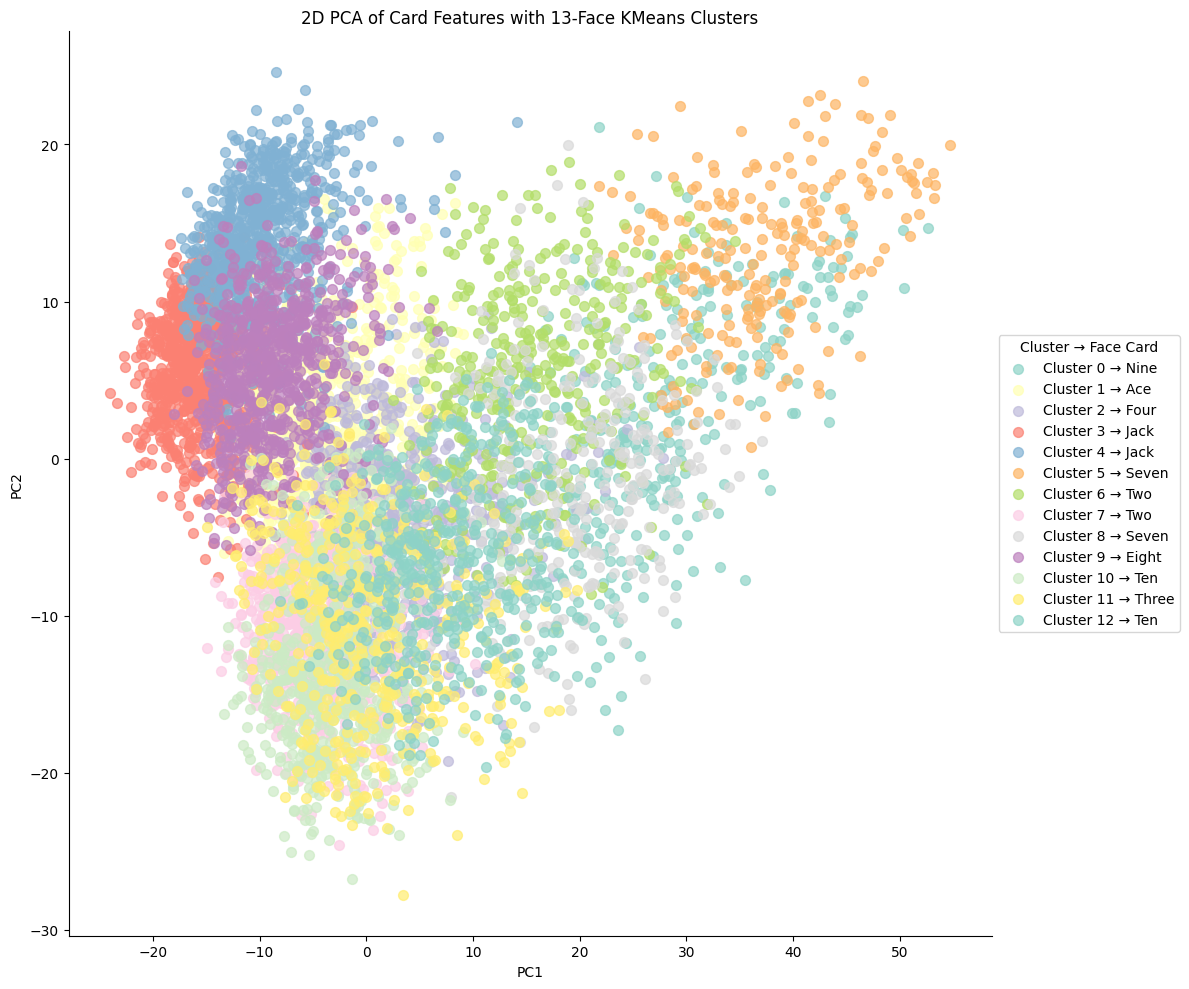

In [13]:
palette = sns.color_palette("Set3", 13)
fig, ax = plt.subplots(figsize=(12, 10))

for c in cluster_to_face:
    mask = face_clusters == c
    ax.scatter(
        points_2d[mask, 0], points_2d[mask, 1],
        color=palette[c], s=50, alpha=0.7,
        label=f"Cluster {c} → {cluster_to_face[c].capitalize()}"
    )

ax.set_title("2D PCA of Card Features with 13-Face KMeans Clusters")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Cluster → Face Card")
sns.despine()
plt.tight_layout()
plt.show()

We got the PCA + K-Means for `k=13`, and the scatterplot shows the points as somewhat tight.

Now we can try PCA + K-Means for k=4, 4 representing the four suits (Diamonds, Hearts, Spades, Clubs). 

In [14]:
pca_2d = PCA(n_components=4, random_state=0)
points_2d = pca_2d.fit_transform(features)
print("PCA variance ratio:", pca_2d.explained_variance_ratio_.round(3))

# cluster into 4 groups (one per suit)
km_suits = KMeans(n_clusters=4, random_state=0)
suit_clusters = km_suits.fit_predict(features)

# extract suit names from labels (hearts, diamonds, etc.)
suit_names = np.array([lbl.split("_")[-1] for lbl in y_train])

cluster_to_suit = {
    c: Counter(suit_names[suit_clusters==c]).most_common(1)[0][0]
    for c in np.unique(suit_clusters)
}

/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/li

PCA variance ratio: [0.153 0.079 0.063 0.048]


We will also show a 2D scatterplot with the PCA features, grouped by KMeans clusters (with the 4 suits).

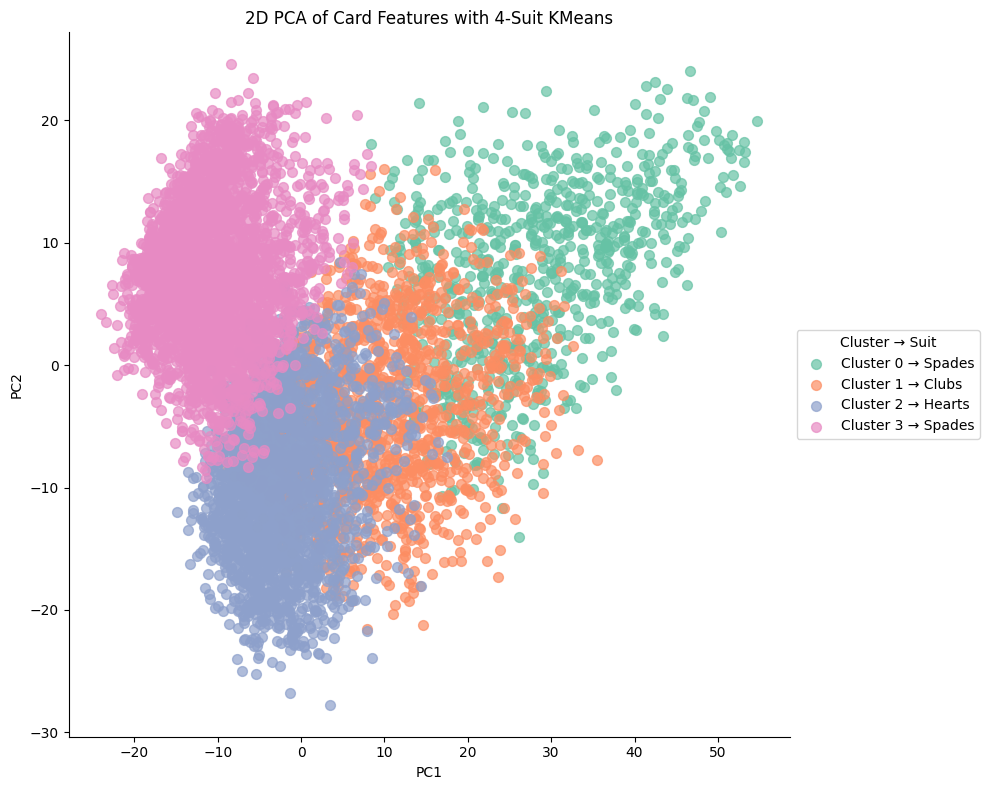

In [15]:
palette = sns.color_palette("Set2", 4)
fig, ax = plt.subplots(figsize=(10, 8))

for c in cluster_to_suit:
    mask = suit_clusters == c
    ax.scatter(
        points_2d[mask, 0], points_2d[mask, 1],
        color=palette[c], s=50, alpha=0.7,
        label=f"Cluster {c} → {cluster_to_suit[c].capitalize()}"
    )

ax.set_title("2D PCA of Card Features with 4-Suit KMeans")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Cluster → Suit")
sns.despine()
plt.tight_layout()
plt.show()

As we can see, the the points for `k=4` K-Means Clustering + PCA are well-clustered and are relatively tight within their own cluster. 

### Silhouette Score

Let's calculate the silhouette scores for k=13 and k=4.

#### k = 13:

In [16]:
sil_score_13 = silhouette_score(features, face_clusters)
print(f"Silhouette Score (k=13): {sil_score_13:.4f}")

/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Silhouette Score (k=13): 0.0576


#### k = 4:

In [17]:
sil_score_4 = silhouette_score(features, suit_clusters)
print(f"Silhouette Score (k=4): {sil_score_4:.4f}")

/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Silhouette Score (k=4): 0.0952


### Silhouette Score Interpretation

This analysis compares clustering effectiveness between two different grouping strategies:
- **k = 13 (face values)**: The silhouette score of 0.0576 shows how well the clusters overlap in a large number of clusters. The lower score indicates more overlap between clusters.
- **k = 4 (suits)**: The silhouette score of 0.0952 shows the consistency across the 4 suits. The higher score indicates better-defined, more distinct clusters; however, since it is still close to 0, we can assume there is a lot of overlap.

A higher silhouette score suggests better-defined clustering.

## Supervised Learning

We'll implement three supervised learning approaches to compare their performance on the playing card classification task:

- **Model A:** Random Forest Classifier (traditional machine learning)

- **Model B:** Transfer Learning with ResNet50 (deep learning)

- **Model C:** Custom CNN (deep learning)

This allows us to compare traditional machine learning with deep learning approaches.

### Model A — Random Forest Classifier

This model uses features extracted from ResNet50 (without fine-tuning) as input from before to the Random Forest classifier.

In [18]:
# split data into training and validation sets
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
    features, y_train_encoded, test_size=0.20, random_state=42
)

# train
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_rf, y_train_rf)

# evaluate on validation set
y_val_pred_rf = rf_classifier.predict(X_val_rf)
accuracy_rf = accuracy_score(y_val_rf, y_val_pred_rf)
print(f"Random Forest Accuracy Score: {accuracy_rf:.4f}")

Random Forest Accuracy Score: 0.4294


Classification Report:
                   precision    recall  f1-score   support

     ace_of_clubs       0.67      0.62      0.64        26
  ace_of_diamonds       0.59      0.55      0.57        29
    ace_of_hearts       0.49      0.76      0.60        34
    ace_of_spades       0.44      0.90      0.60        31
   eight_of_clubs       0.27      0.11      0.16        35
eight_of_diamonds       0.33      0.39      0.36        28
  eight_of_hearts       0.32      0.43      0.36        28
  eight_of_spades       0.19      0.18      0.18        17
    five_of_clubs       0.39      0.52      0.44        33
 five_of_diamonds       0.68      0.39      0.50        38
   five_of_hearts       0.42      0.35      0.38        23
   five_of_spades       0.44      0.40      0.42        30
    four_of_clubs       0.50      0.59      0.54        39
 four_of_diamonds       0.53      0.38      0.44        26
   four_of_hearts       0.31      0.41      0.35        27
   four_of_spades       0.67    

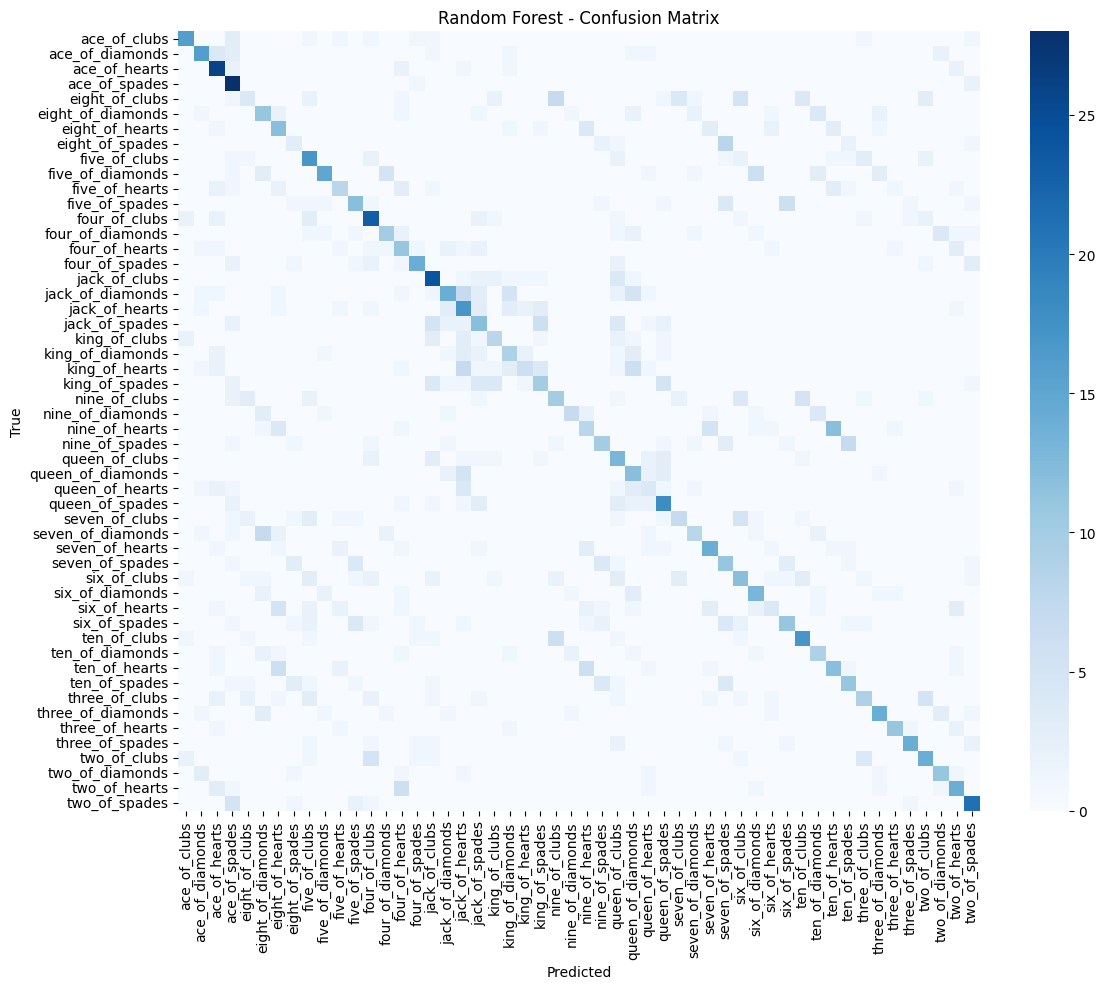

In [19]:
print("Classification Report:")
print(classification_report(y_val_rf, y_val_pred_rf, target_names=label_encoder.classes_))

# create confusion matrix
conf_matrix_rf = confusion_matrix(y_val_rf, y_val_pred_rf)

# visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_rf, annot=False, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Now that we have extracted features and trained a Random Forest classifier using these features, let's also try predicting on the test set to compare with our other models.

In [20]:
# prepare test data
X_test_prepped = preprocess_input(X_test.astype('float32'))
test_features = backbone.predict(X_test_prepped, batch_size=32, verbose=1)

# evaluate model on test set
y_test_pred_rf = rf_classifier.predict(test_features)
accuracy_rf_test = accuracy_score(y_test_encoded, y_test_pred_rf)
print(f"Random Forest Test Accuracy Score: {accuracy_rf_test:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Random Forest Test Accuracy Score: 0.4769


As you can see, the accuracy score is ~47%. This is expected for this model. Considering the number of features, this performed relatively well, but this is not usable in a real-world. We noticed that from the confusion matrix, there was some areas where the model fails in recognizing the cards. Therefore, this model is quick to train and serves as a good baseline.

### Model B — Transfer Learning with ResNet50

For our second supervised learning approach, we'll use transfer learning with ResNet50 as the backbone from before. This model fine-tuned a ResNet50 pretrained on ImageNet, using our playing card dataset.

In [21]:
# create base model from pre-trained ResNet50
base_model = ResNet50(weights='imagenet', 
                     include_top=False, 
                     input_shape=(224, 224, 3))

# freeze pre-trained layers to preserve learned features
for layer in base_model.layers:
    layer.trainable = False

# define number of classes before using it
num_classes = len(encoded_dict)

# add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# construct final model
model_b = Model(inputs=base_model.input, outputs=predictions)

# compile with appropriate loss and optimizer
model_b.compile(optimizer=Adam(learning_rate=0.0001),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model_b.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,739,188 (98.19 MB)

 Trainable params: 2,151,476 (8.21 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
# configure early stopping to prevent overfitting (we use this for all models)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train
history_b = model_b.fit(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=30, # 30 epochs, takes a while
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.0630 - loss: 4.9406 - val_accuracy: 0.2615 - val_loss: 2.5136
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.1735 - loss: 3.5787 - val_accuracy: 0.3308 - val_loss: 2.1625
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.2272 - loss: 3.1775 - val_accuracy: 0.3923 - val_loss: 1.9635
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step - accuracy: 0.2762 - loss: 2.9011 - val_accuracy: 0.4154 - val_loss: 1.8194
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.3229 - loss: 2.6542 - val_accuracy: 0.4154 - val_loss: 1.7747
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.3605 - loss: 2.4172 - val_accuracy: 0.4654 - val_loss: 1.6780
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.3874 - loss: 2.2880 - val_accuracy: 0.4769 - val_loss: 1.6889
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.4273 - loss: 2

Trained for 30 epochs


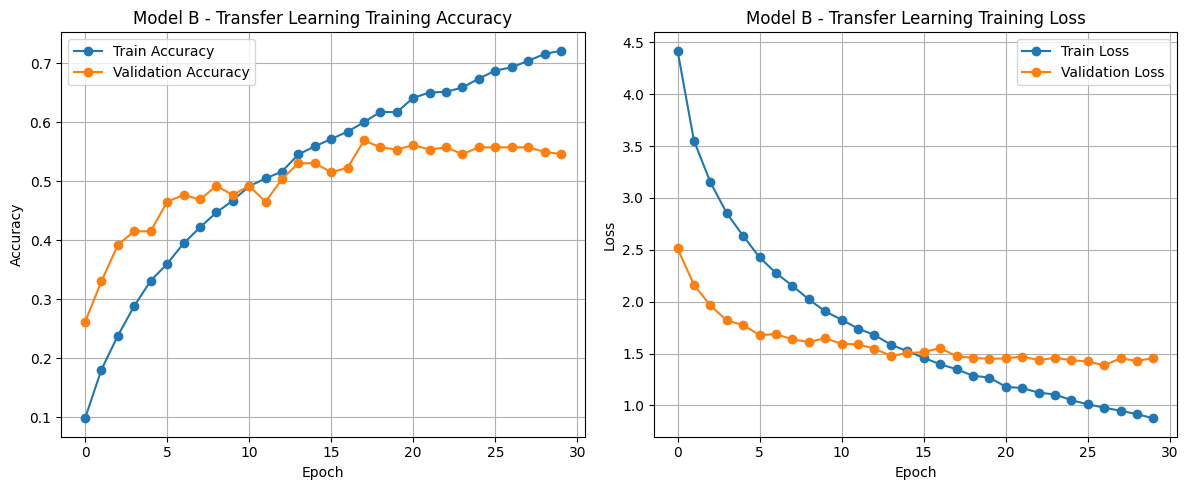

In [23]:
print(f"Trained for {len(history_b.history['loss'])} epochs")

plt.figure(figsize=(12, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_b.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_b.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model B - Transfer Learning Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# loss plot
plt.subplot(1, 2, 2)
plt.plot(history_b.history['loss'], label='Train Loss', marker='o')
plt.plot(history_b.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model B - Transfer Learning Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
y_pred_b = model_b.predict(X_test, batch_size=32)
y_pred_labels_b = np.argmax(y_pred_b, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step


Classification Report for Model B (Transfer Learning):
                   precision    recall  f1-score   support

     ace_of_clubs       0.75      0.60      0.67         5
  ace_of_diamonds       1.00      1.00      1.00         5
    ace_of_hearts       0.60      0.60      0.60         5
    ace_of_spades       0.83      1.00      0.91         5
   eight_of_clubs       0.67      0.40      0.50         5
eight_of_diamonds       0.27      0.60      0.38         5
  eight_of_hearts       0.83      1.00      0.91         5
  eight_of_spades       0.25      0.20      0.22         5
    five_of_clubs       0.20      0.40      0.27         5
 five_of_diamonds       0.50      0.60      0.55         5
   five_of_hearts       0.71      1.00      0.83         5
   five_of_spades       0.60      0.60      0.60         5
    four_of_clubs       0.40      0.40      0.40         5
 four_of_diamonds       1.00      0.80      0.89         5
   four_of_hearts       0.80      0.80      0.80         5


/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

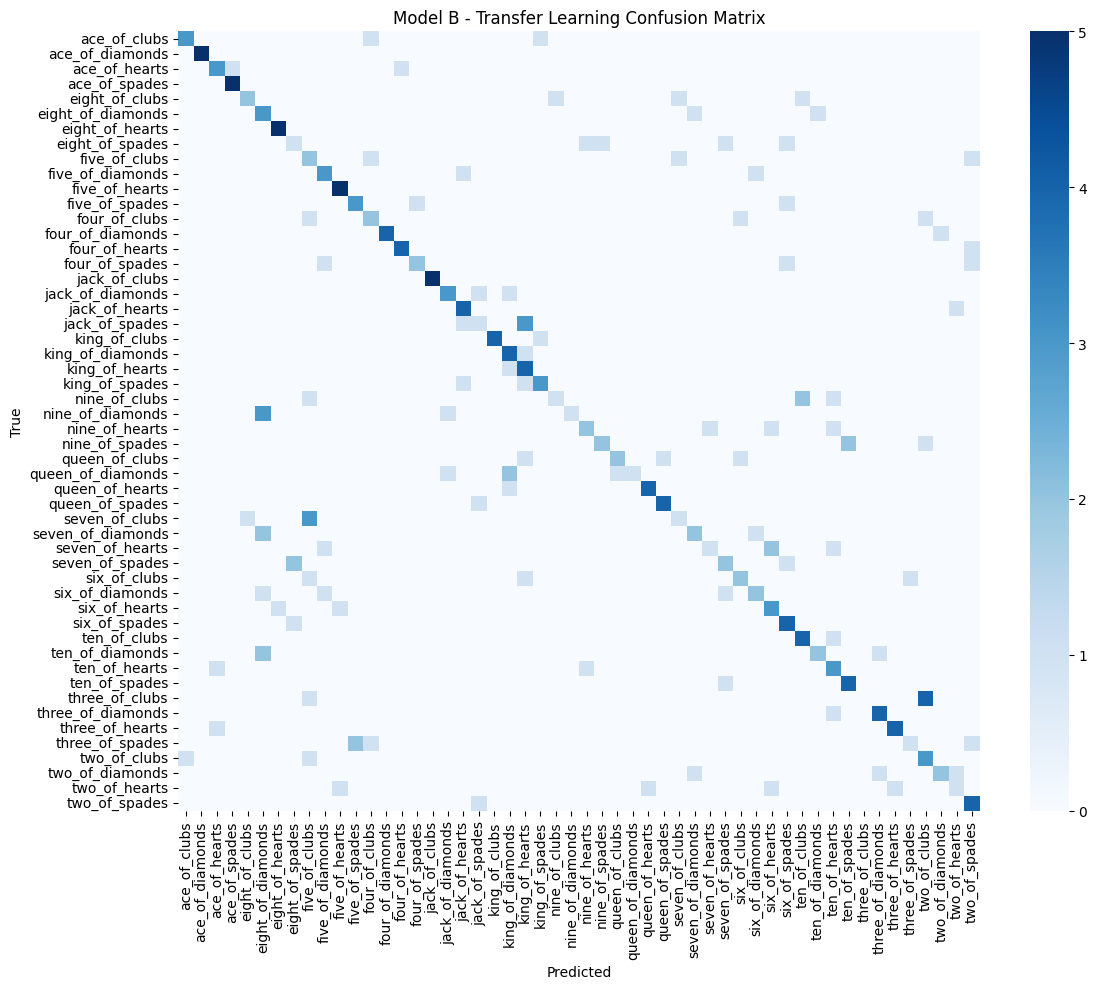

In [25]:
print("Classification Report for Model B (Transfer Learning):")
print(classification_report(y_test_encoded, y_pred_labels_b, target_names=label_encoder.classes_))

conf_mat_b = confusion_matrix(y_test_encoded, y_pred_labels_b)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat_b, annot=False, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Model B - Transfer Learning Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

As you can see, the accuracy score is ~56%. This is a noticeable jump from Model A Random Forest Classifier. By using existing learned features, this model achieved better performance. It required minimal training time for the performance it outputted and generalized well, even with limited data.

### Model C — Custom CNN

This model is a custom CNN, built without using any pre-existing weights or features. Therefore, it's more challenging to tune and train due to the numerous variables across its many layers. We expect a higher computational time for training this model, with the expectation of achieving a higher accuracy score.

In [26]:
# define model architecture
input_shape = (224, 224, 3)
num_classes = len(encoded_dict)

# build sequential CNN model
model_c = Sequential([
    # layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # layer 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# compile
model_c.compile(optimizer=Adam(learning_rate=0.0005),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_c.summary()

/Users/saketh/Developer/GitHub/DAT402Project2/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 52)             │        13,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,258,932 (84.91 MB)

 Trainable params: 22,258,484 (84.91 MB)

 Non-trainable params: 448 (1.75 KB)

In [27]:
# same early stop as before
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# train
history_c = model_c.fit(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.1020 - loss: 42.7855 - val_accuracy: 0.3731 - val_loss: 25.0546
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - accuracy: 0.2852 - loss: 41.2979 - val_accuracy: 0.5000 - val_loss: 33.9066
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - accuracy: 0.3764 - loss: 41.6235 - val_accuracy: 0.6500 - val_loss: 22.5858
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.4991 - loss: 33.1709 - val_accuracy: 0.6923 - val_loss: 22.4967
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.5834 - loss: 27.7878 - val_accuracy: 0.6577 - val_loss: 34.8738
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - accuracy: 0.6551 - loss: 23.7169 - val_accuracy: 0.7423 - val_loss: 22.5583
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - accuracy: 0.7385 - loss: 17.0706 - val_accuracy: 0.7577 - val_loss: 20.5401
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - accuracy: 0.

Trained for 15 epochs


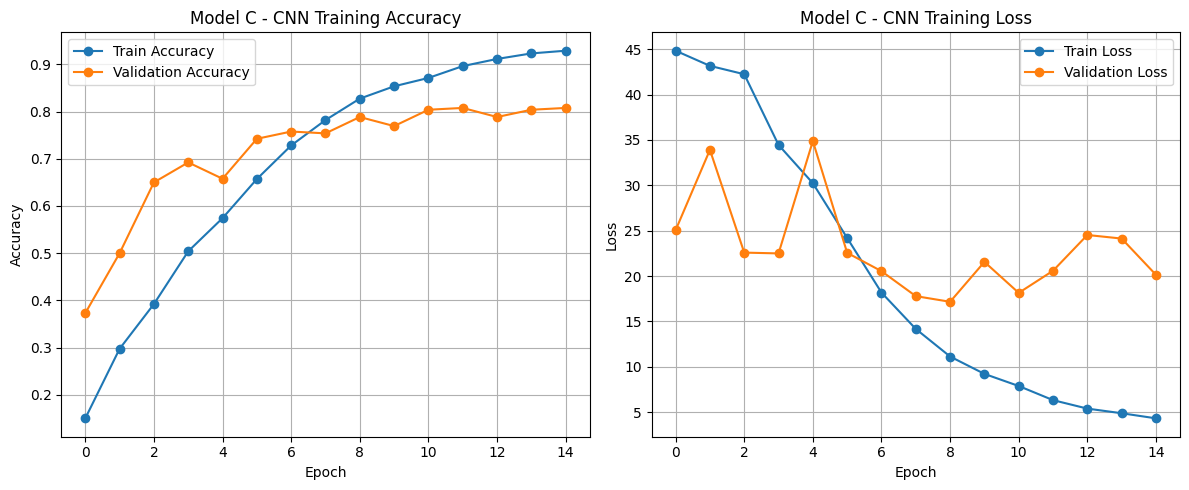

In [28]:
print(f"Trained for {len(history_c.history['loss'])} epochs")

plt.figure(figsize=(12, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_c.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_c.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model C - CNN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# loss plot
plt.subplot(1, 2, 2)
plt.plot(history_c.history['loss'], label='Train Loss', marker='o')
plt.plot(history_c.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model C - CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Classification Report for Model C:
                   precision    recall  f1-score   support

     ace_of_clubs       0.67      0.80      0.73         5
  ace_of_diamonds       1.00      0.80      0.89         5
    ace_of_hearts       1.00      1.00      1.00         5
    ace_of_spades       1.00      1.00      1.00         5
   eight_of_clubs       0.50      0.80      0.62         5
eight_of_diamonds       0.45      1.00      0.62         5
  eight_of_hearts       0.83      1.00      0.91         5
  eight_of_spades       1.00      0.40      0.57         5
    five_of_clubs       1.00      0.60      0.75         5
 five_of_diamonds       1.00      0.60      0.75         5
   five_of_hearts       1.00      0.80      0.89         5
   five_of_spades       1.00      0.80      0.89         5
    four_of_clubs       1.00      0.60      0.75         5
 four_of_diamonds       0.80      0.80      0.80         5
   four_of_hearts       0.83      1.00   

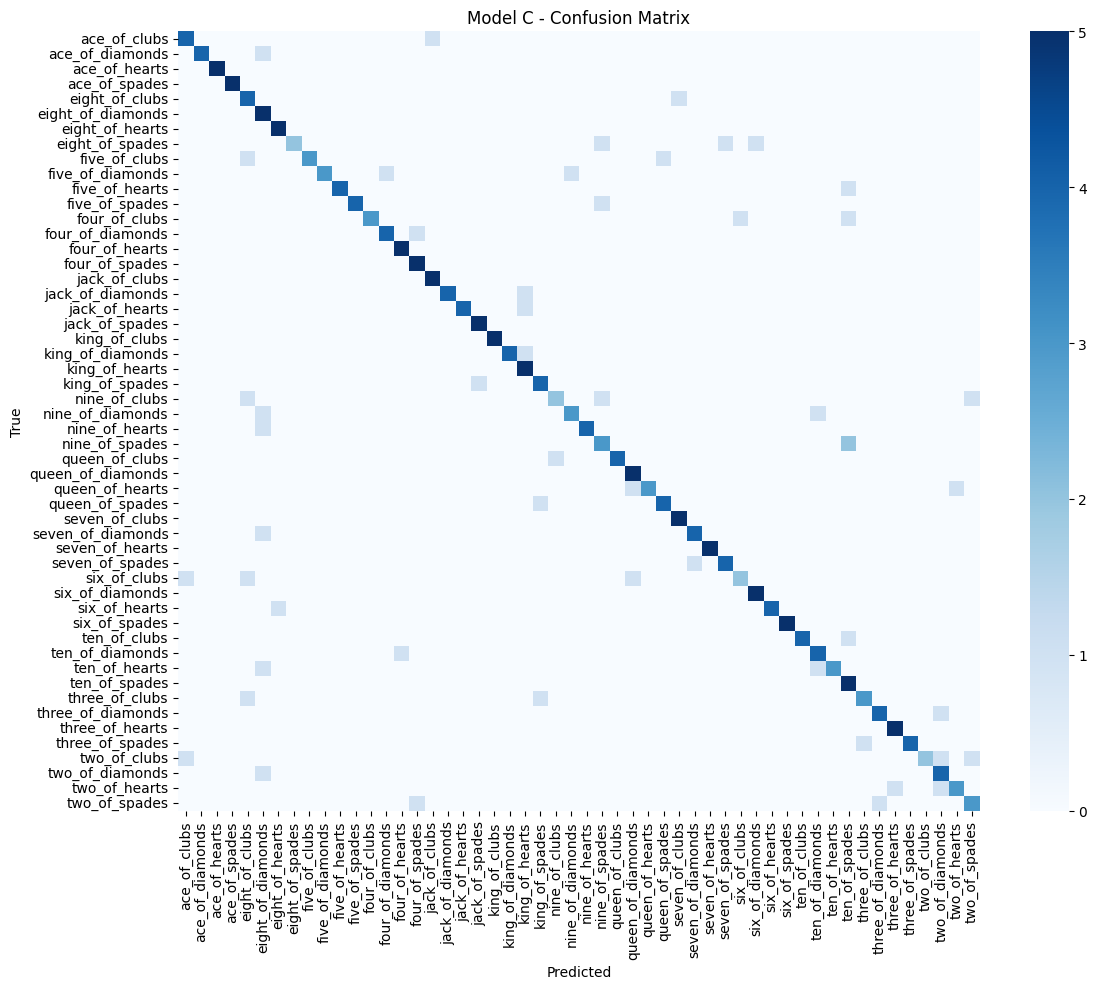

In [29]:
# generate predictions on test data
y_pred_c = model_c.predict(X_test, batch_size=32)
y_pred_labels_c = np.argmax(y_pred_c, axis=1)

print("Classification Report for Model C:")
print(classification_report(y_test_encoded, y_pred_labels_c, target_names=label_encoder.classes_))

conf_mat_c = confusion_matrix(y_test_encoded, y_pred_labels_c)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat_c, annot=False, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Model C - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

The custom CNN model outputs the best performance, achieving an accuracy score of ~80%. Further improvements could be explored by tweaking the model's parameters or adding more layers. Based on the confusion matrix, we observe that the model still struggles to accurately classify face cards such as kings, queens, and jacks. Nevertheless, its performance is significantly better than the previous models we tested.

## Model Comparison and Analysis

Now, let's compare the performance of all three models (Model A: Random Forest, Model B: Transfer Learning with ResNet50, and Model C: Custom CNN) to understand their strengths and weaknesses.

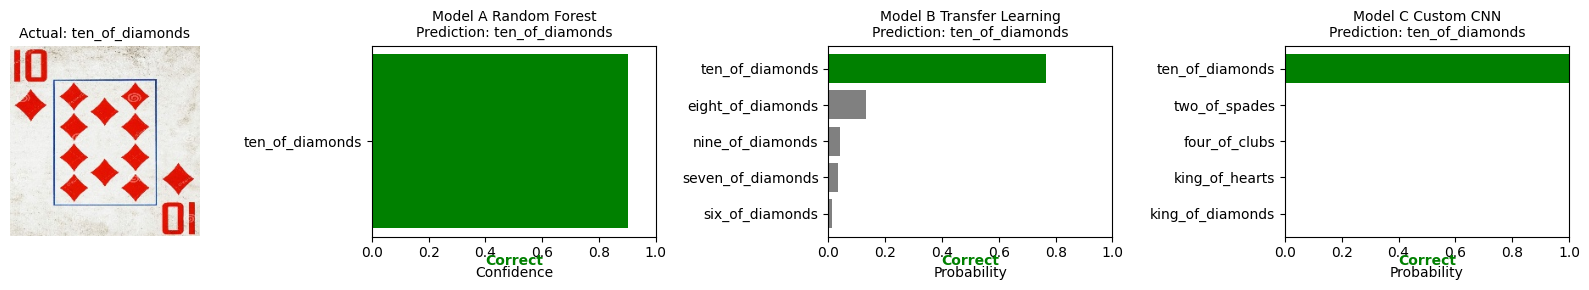

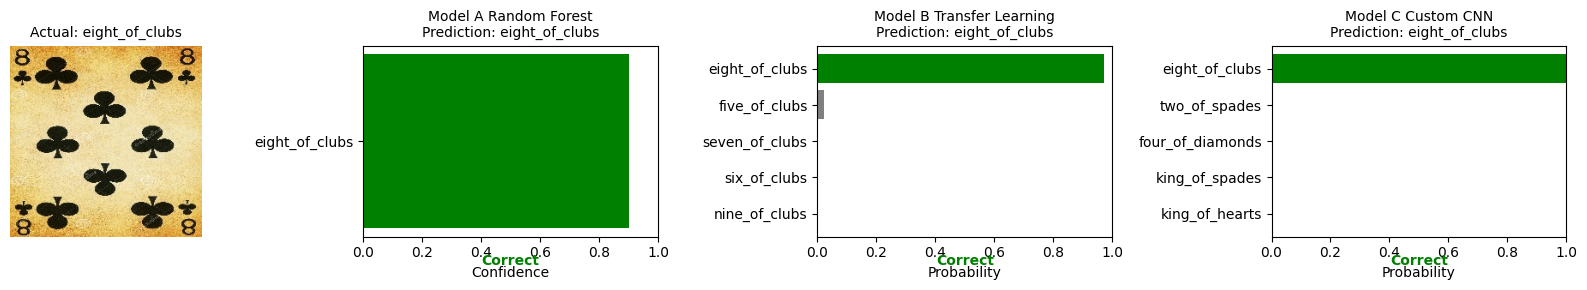

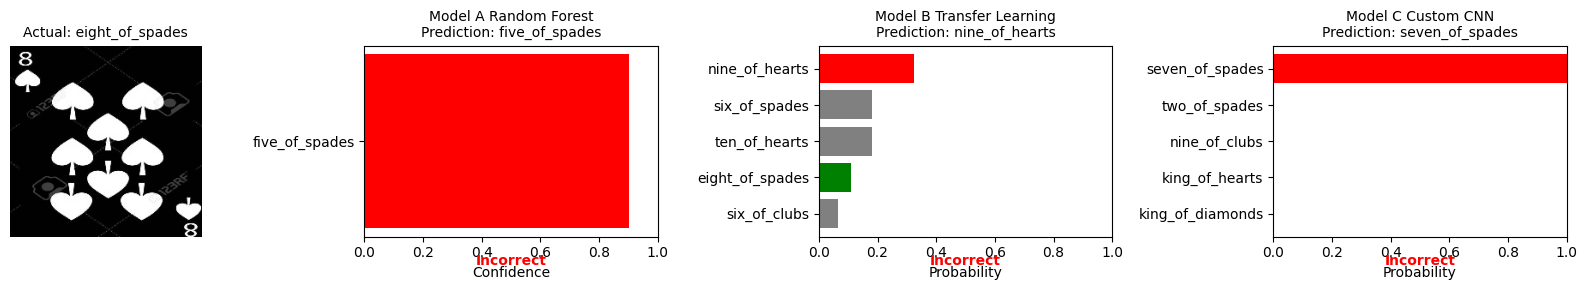

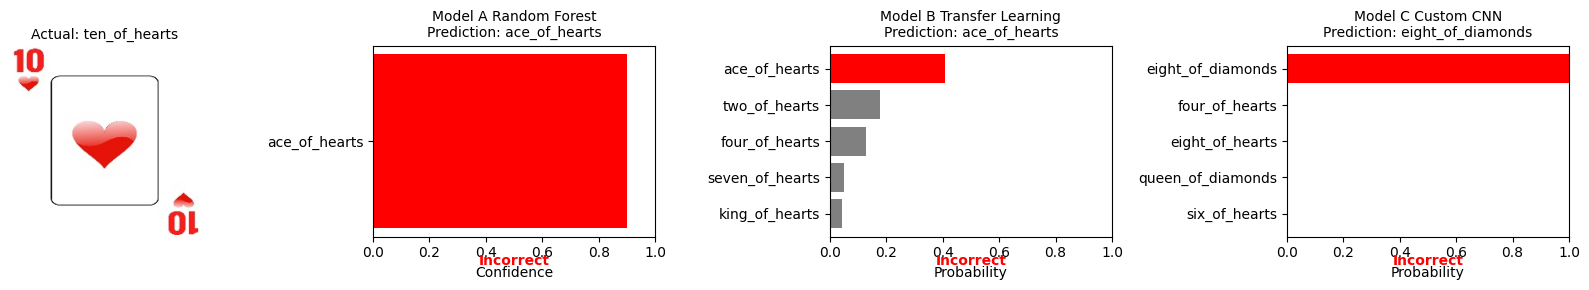

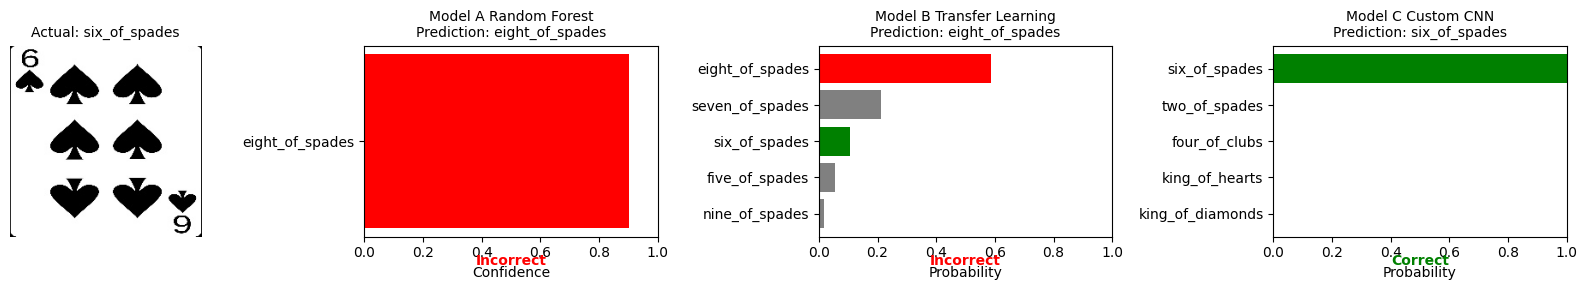

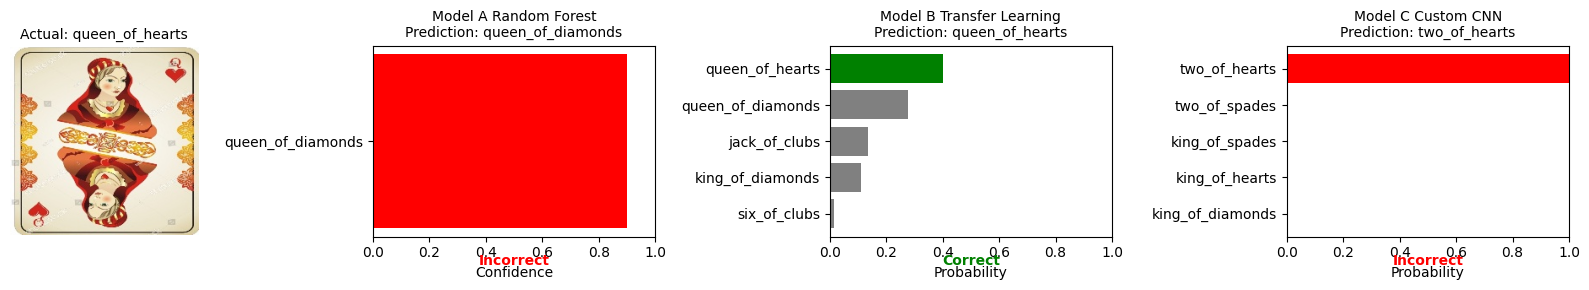

In [30]:
def compare_model_predictions(test_indices, predictions_list, model_names):
    """shows how different models perform on the same card images"""
    for idx in test_indices:
        # get the actual card
        actual_label = y_test[idx]
        fig, axes = plt.subplots(1, 4, figsize=(16, 3), gridspec_kw={'width_ratios': [1, 1.5, 1.5, 1.5]})
        
        # show the card image
        axes[0].imshow(X_test[idx].astype("uint8"))
        axes[0].axis('off')
        axes[0].set_title(f"Actual: {actual_label}", fontsize=10)
        
        # display each model's prediction
        for i, (y_pred, model_name) in enumerate(zip(predictions_list, model_names)):
            # handle different model output formats
            if i == 0:  # random forest case
                pred_class = y_pred[idx]
                pred_label = label_encoder.inverse_transform([pred_class])[0]
                # create simple display for RF (no probability distribution)
                class_probs = np.zeros(len(label_encoder.classes_))
                class_probs[pred_class] = 0.9
                top_5_indices = np.array([pred_class])
                class_probs_df = pd.DataFrame({
                    "label": label_encoder.classes_[top_5_indices],
                    "prob": class_probs[top_5_indices]
                })
            else:  # neural network cases
                pred_probs = y_pred[idx]
                pred_class = np.argmax(pred_probs)
                pred_label = label_encoder.inverse_transform([pred_class])[0]
                top_5_indices = np.argsort(pred_probs)[-5:][::-1]
                class_probs_df = pd.DataFrame({
                    "label": label_encoder.classes_[top_5_indices],
                    "prob": pred_probs[top_5_indices]
                })

            # color them
            colors = ["gray"] * len(class_probs_df)
            if pred_label in class_probs_df["label"].values:
                pred_idx = class_probs_df["label"].tolist().index(pred_label)
                colors[pred_idx] = "red"
            if actual_label in class_probs_df["label"].values:
                act_idx = class_probs_df["label"].tolist().index(actual_label)
                colors[act_idx] = "green"

            ax = axes[i+1]
            ax.barh(class_probs_df["label"], class_probs_df["prob"], color=colors)
            ax.invert_yaxis()
            ax.set_xlim(0, 1)
            ax.set_title(f"{model_name}\nPrediction: {pred_label}", fontsize=10)
            ax.set_xlabel("Probability" if i > 0 else "Confidence")
            
            # show if the prediction was right
            correct = pred_label == actual_label
            ax.text(0.5, -0.15, f"{'Correct' if correct else 'Incorrect'}", 
                   transform=ax.transAxes, ha='center', 
                   color='green' if correct else 'red', fontweight='bold')
            
        plt.tight_layout()
        plt.show()

# gather predictions from all models
rf_predictions = y_test_pred_rf
cnn_predictions = y_pred_c
transfer_predictions = y_pred_b

# convert neural network outputs to predicted classes
model_b_preds = np.argmax(transfer_predictions, axis=1)
model_c_preds = np.argmax(cnn_predictions, axis=1)

# find interesting cases to compare
all_correct = np.where((model_b_preds == y_test_encoded) & 
                       (model_c_preds == y_test_encoded) & 
                       (rf_predictions == y_test_encoded))[0]

all_wrong = np.where((model_b_preds != y_test_encoded) & 
                     (model_c_preds != y_test_encoded) & 
                     (rf_predictions != y_test_encoded))[0]

mixed_results = np.where(((model_b_preds == y_test_encoded) & 
                          (model_c_preds != y_test_encoded)) | 
                         ((model_b_preds != y_test_encoded) & 
                          (model_c_preds == y_test_encoded)) |
                         ((rf_predictions == y_test_encoded) & 
                          (model_c_preds != y_test_encoded)))[0]

# pick examples from each category
samples = (
    list(np.random.choice(all_correct, size=min(2, len(all_correct)), replace=False)) + 
    list(np.random.choice(all_wrong, size=min(2, len(all_wrong)), replace=False)) + 
    list(np.random.choice(mixed_results, size=min(2, len(mixed_results)), replace=False))
)

compare_model_predictions(
    samples,
    [rf_predictions, transfer_predictions, cnn_predictions],
    ["Model A Random Forest", "Model B Transfer Learning", "Model C Custom CNN"]
)

Model Performance Comparison:
                       Model  Test Accuracy
0      Model A Random Forest       0.476923
1  Model B Transfer Learning       0.561538
2         Model C Custom CNN       0.796154


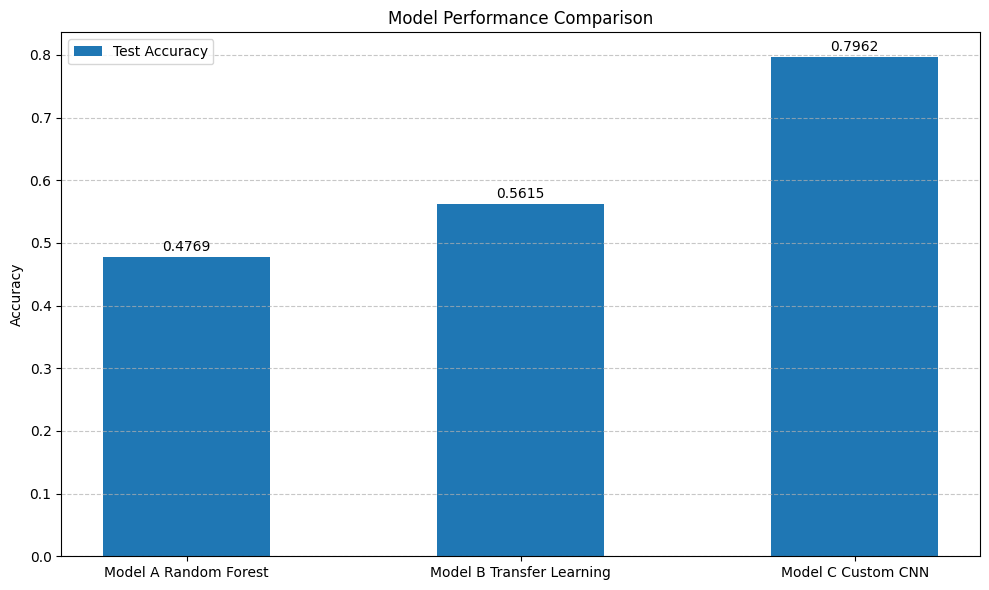

In [31]:
# convert random forest predictions to probability format
y_pred_rf_probs = np.zeros((len(y_test_pred_rf), num_classes))
for i, pred in enumerate(y_test_pred_rf):
    y_pred_rf_probs[i, pred] = 1

# gather accuracy metrics for all models
models = ['Model A Random Forest', 'Model B Transfer Learning', 'Model C Custom CNN']
test_accuracy = [
    metrics.accuracy_score(y_test_encoded, y_test_pred_rf),
    metrics.accuracy_score(y_test_encoded, y_pred_labels_b),
    metrics.accuracy_score(y_test_encoded, y_pred_labels_c)
]

# create comparison table
comparison_df = pd.DataFrame({
    'Model': models,
    'Test Accuracy': test_accuracy
})

print("Model Performance Comparison:")
print(comparison_df)

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.5

plt.bar(x, test_accuracy, width, label='Test Accuracy')

plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(test_accuracy):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

## Implications & Limitations

- PCA + K-means clustering showed suits are more visually distinct than face values, aided by strong color and symbol cues. The Silhouette scores still indicate that the clusters heavily overlapped, resulting in scores close to 0. (~0.05 and ~0.09)

- We noticed that some images were not very clear, which ended up harming the predictive capabilities of our models. This definetely does test the accuracy, but may also hurt the training process. Models may struggle with damaged cards, extreme angles, or custom designs not seen in training.

- Some limitations we came across was the computation time and resources that our personal computers needed to delegate for training the Transfer Learning and CNN methods. 

- Our dataset having ~8,000 images also made it hard to speed up the training process, which we had to work around by providing the ResNet50 Feature Extraction. 


## Conclusion

In this project, we developed and evaluated three classification models for playing card recognition: 
- Random Forest (~47% accuracy)
- ResNet50 Transfer Learning (~56% accuracy)
- Custom CNN (~80% accuracy)

Overall, we found that the Custom CNN was the most effective and provided the highest accuracy. We used multiple layers and built this CNN from the ground up, and did not use the ResNet50 model for feature extraction, unlike the Random Forest Classifier and the Transfer Learning methods. 

Looking at the confusion matrices of each model, we also noticed that the models struggled with accurately identifying Jacks and Kings. 

When using the Random Forest Classifier, we were able to the train the model in a very short time, but that reflected with our much lower accuracy scores (~45%). 

As the Transfer Learning and RF Classifier utilized ResNet50 for feature extraction, to improve the accuracy, future work could include fine-tuning ResNet, using data augmentation, and testing with real-world images or videos.